# Load Libraries

In [2]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
from PIL import Image
from torchvision import datasets, models
import importlib
from face_detection import Detector
from collections import Counter
from torchvision.models import ResNet50_Weights
from facenet_pytorch import InceptionResnetV1
import seaborn as sns
import itertools
import warnings

manual_seed = 999
random.seed(manual_seed)
torch.manual_seed(manual_seed)
torch.use_deterministic_algorithms(True)
generator = torch.Generator().manual_seed(manual_seed)

# Load dataset

If you're training on gpu, set ngpu = 1

if you're training on cpu, ngpu can be anything

In [3]:
dataset_path = 'dataset-merge'
dataset_path = 'utk-dataset-clip'
dataset_path = 'dataset-merge-clip'
dataset_path = 'utk-dataset-crop-jpg'
dataset_path = 'utk-dataset'
workers = 2
batch_size = 100
num_epochs = 50
lr = 0.0001
image_size = 224
# number of available gpu's
ngpu = 1
# num of image channels
nc = 3
nf = 32

In [4]:
device = torch.device('cuda:0' if (torch.cuda.is_available() and ngpu > 0) else 'cpu')
print(device.type)

cuda


In [5]:
image_limit = 5000

class RegressionDataset(Dataset):

    def __init__(self, transform=None) -> None:
        super().__init__()
        self.transform = transform
        self.paths = [item for sublist in [[os.path.join(x, y) for y in os.listdir(x)] for x in [os.path.join(dataset_path, x) for x in os.listdir(dataset_path)]] for item in sublist]
        occur_dict = {}
        for a in range(1, 100+1):
            occur_dict[a] = 0
        
        new_paths = []
        for path in self.paths:
            age = int(path.split('/')[-2])
            if occur_dict[age] > image_limit:
                continue
            occur_dict[age] += 1
            new_paths.append(path)
        self.paths = new_paths
        
        self.labels = [float(x.split('/')[-2]) for x in self.paths]
        # self.labels = [(x - 50) / 50 for x in self.labels]
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        
        
        path = self.paths[index]
        label = self.labels[index]
        img = cv2.imread(path)
        if img is None:
            path = 'dawid.jpeg'
            label = 21
            img = cv2.imread(path)
        img = Image.fromarray(img, mode='RGB')

        problem_file = f'Error file:{path} {index}'
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],)
])

regression_dataset = RegressionDataset(transform=transform)

train_len, test_len = int(0.8 * len(regression_dataset)), int(0.1 * len(regression_dataset))
val_len = len(regression_dataset) - train_len - test_len
                                                              
train_dt, test_dt, val_dt = random_split(regression_dataset, [train_len, test_len, val_len], generator)
train_dl = DataLoader(train_dt, batch_size=batch_size, shuffle=True, num_workers=workers)
test_dl = DataLoader(test_dt, batch_size=len(test_dt), num_workers=workers)
val_dl = DataLoader(val_dt, batch_size=len(test_dt), num_workers=workers)

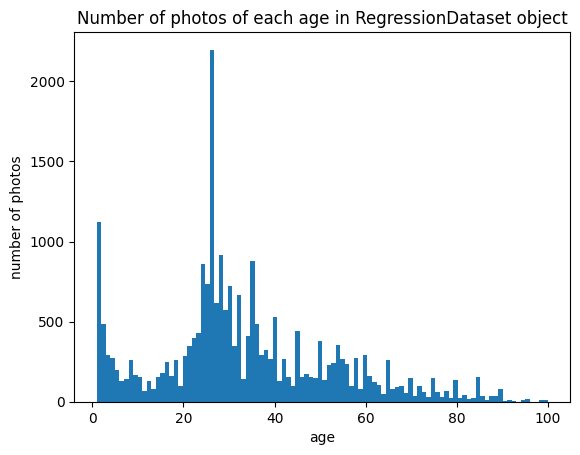

In [6]:
plt.hist([round(x) for x in regression_dataset.labels], bins=100)
plt.title('Number of photos of each age in RegressionDataset object')
plt.xlabel('age')
plt.ylabel('number of photos')
plt.show()

## Plot dataset images

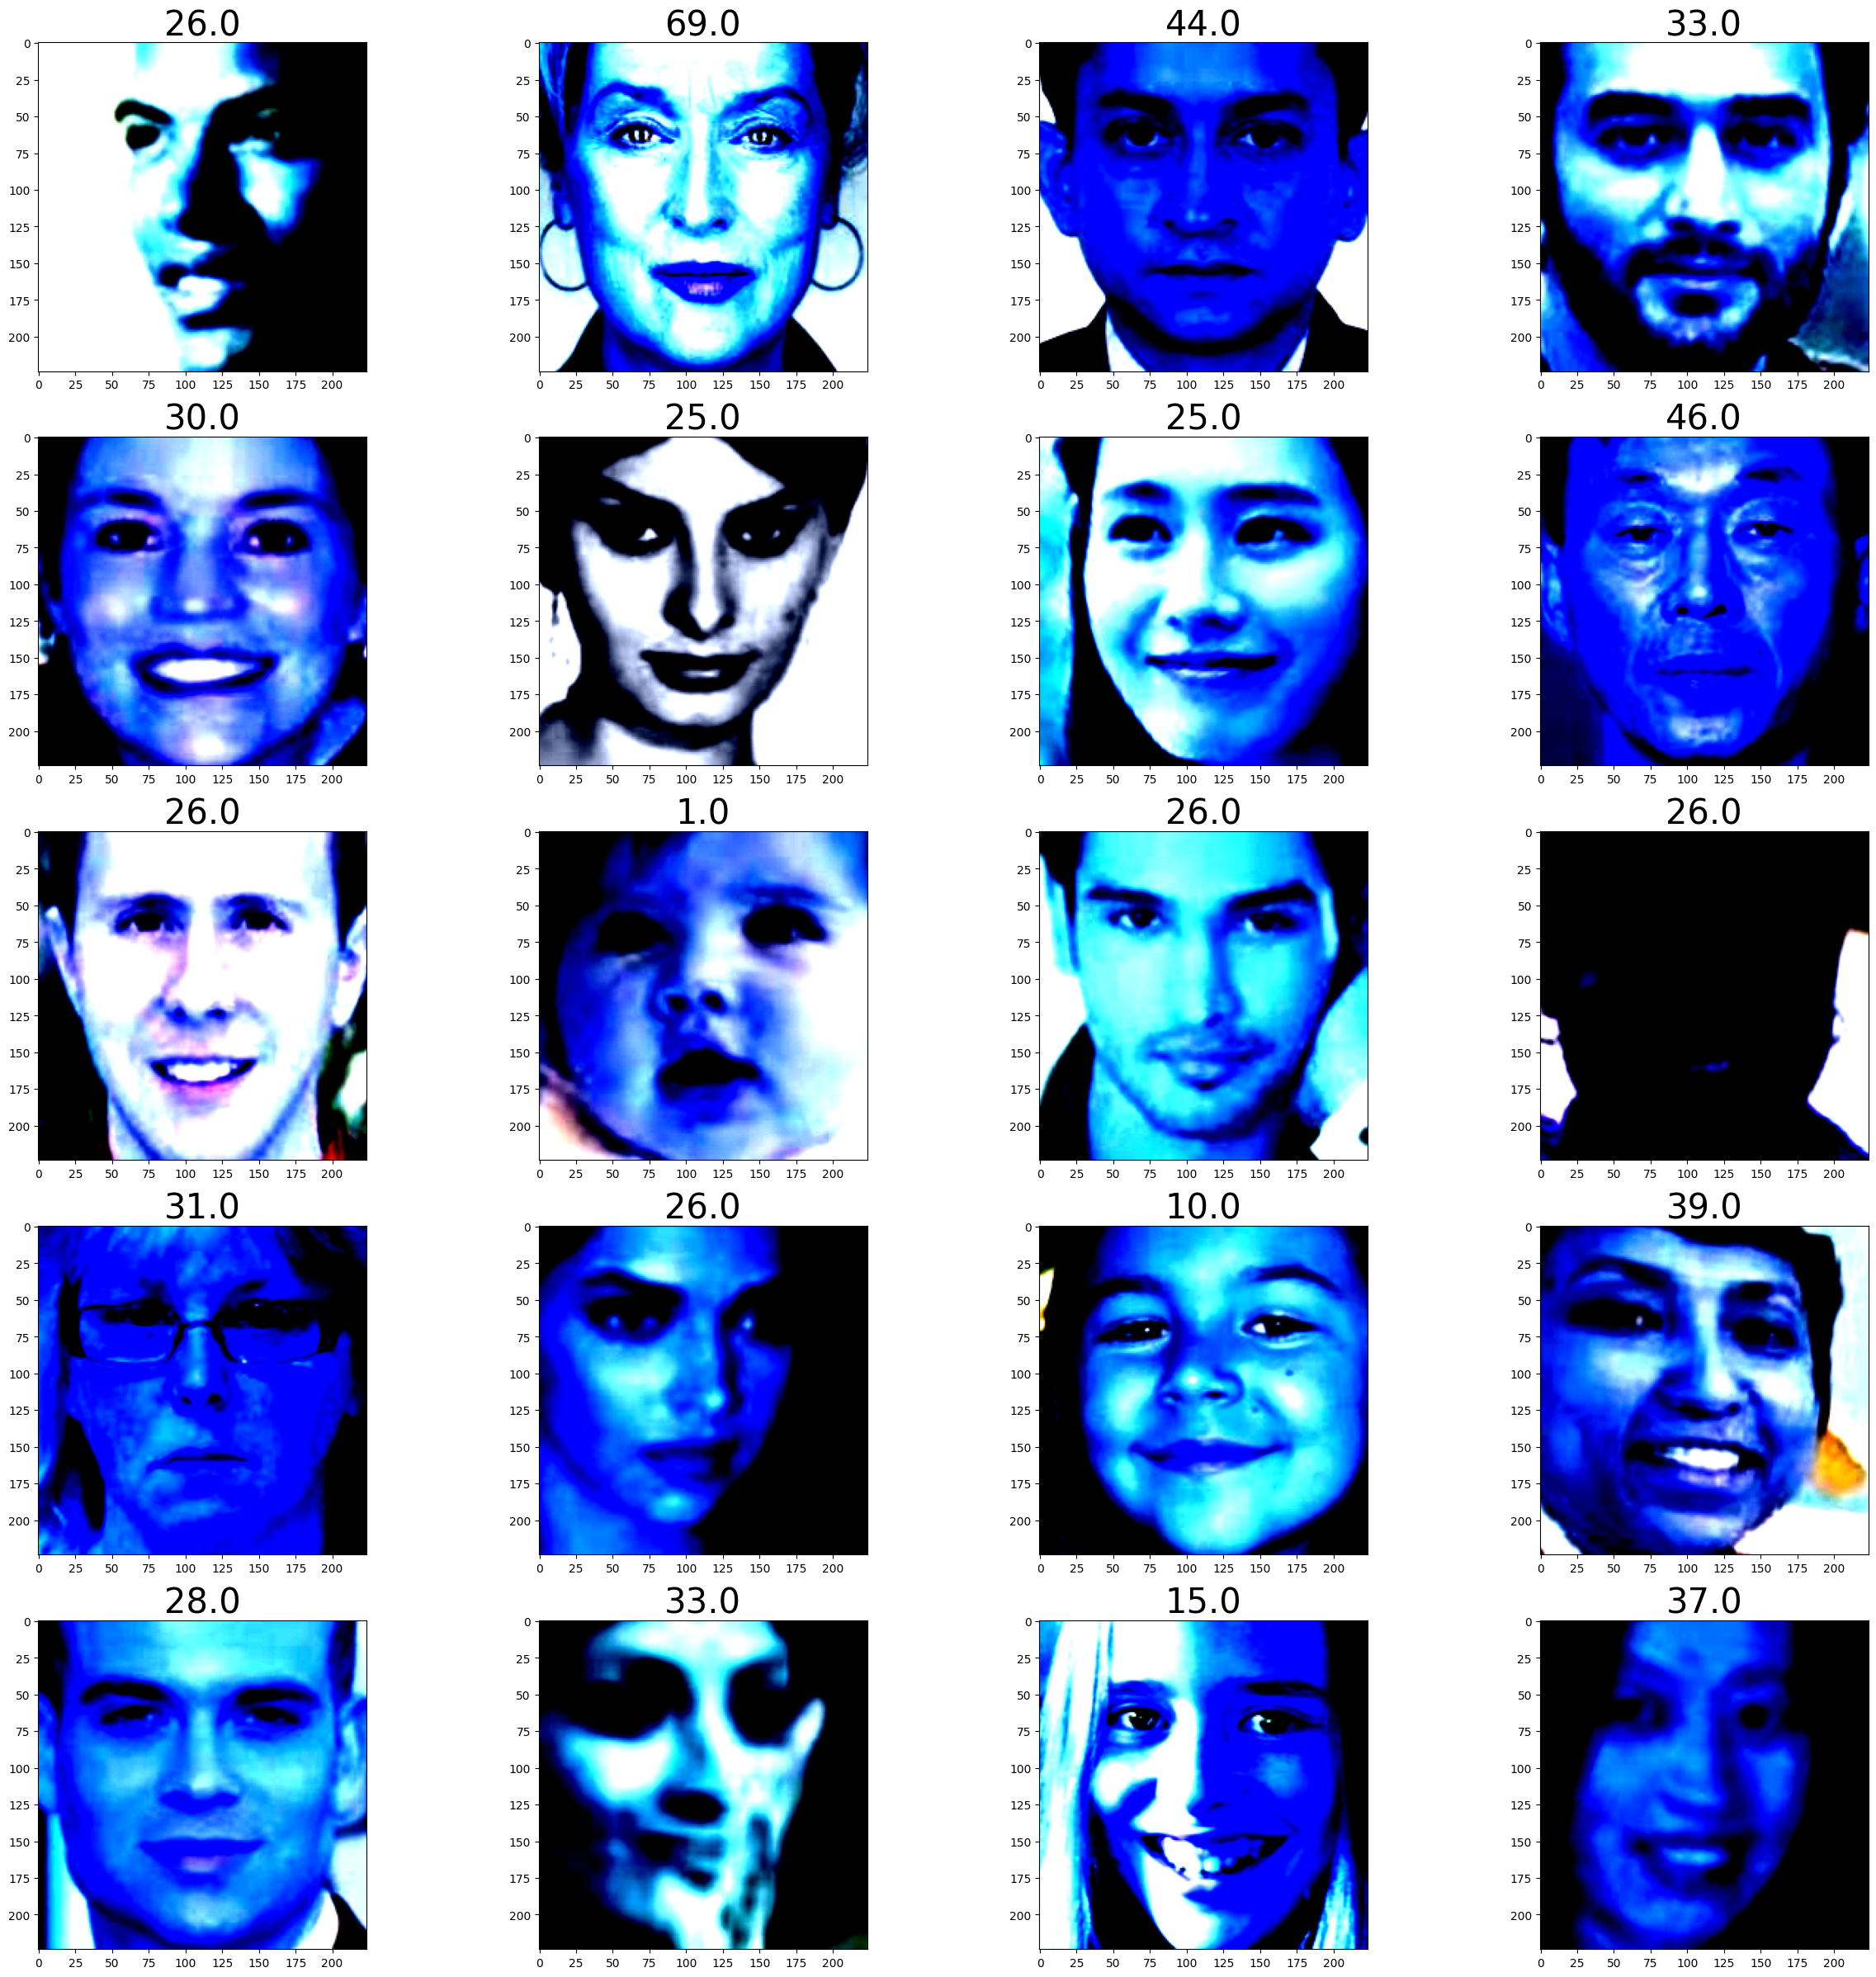

In [7]:
fig = plt.figure(figsize=(30,30))
plot_rows = 5
plot_cols = 4
for i in range(plot_rows * plot_cols):
    a = fig.add_subplot(plot_rows, plot_cols, i+1)
    idx = random.randint(0, len(regression_dataset)-1)
    a.set_title(str(regression_dataset[idx][1]), fontsize=30)
    plt.imshow(np.clip(regression_dataset[idx][0].permute(1,2,0),0,1)) 

# Inception ResNet

In [8]:
class InceptionNetwork(nn.Module):
    
    def __init__(self, ngpu):
        super(InceptionNetwork, self).__init__()
        self.ngpu = ngpu
        self.float()
        
        inc_model = InceptionResnetV1(pretrained='vggface2').to(device).eval()
        for param in inc_model.parameters():
            param.requires_grad = False
        self.inc_model = inc_model
        
        self.head_network = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            
            nn.Linear(512, 1)
        )
    
    def forward(self, input_img):
        inc_res = self.inc_model(input_img)
        head_res = self.head_network(inc_res)
        return head_res

In [9]:
model = InceptionNetwork(ngpu=ngpu).to(device)
transform.__init__([
    transforms.ToTensor()
])
image_size = -1

## Test if output is of shape (1, 1)

In [12]:
torch.use_deterministic_algorithms(False)

In [13]:
test_img = cv2.imread('dawid.jpeg')
test_img = Image.fromarray(test_img, mode='RGB')
test_img = transform(test_img).to(device).detach()
test_img = test_img.reshape((1, 3, test_img.shape[1], test_img.shape[2]))
model(test_img).shape

torch.Size([1, 1])

## Load data

In [70]:
train_dl = DataLoader(train_dt, batch_size=batch_size, shuffle=True, num_workers=workers)
test_dl = DataLoader(test_dt, batch_size=batch_size, num_workers=workers)
val_dl = DataLoader(val_dt, batch_size=batch_size, num_workers=workers)

'\ntest_data, test_label = next(iter(test_dl))\nval_data, val_label = next(iter(val_dl))\n\ntest_data, test_label = test_data.detach(), test_label.detach()\nval_data, val_label = val_data.detach(), val_label.detach()\n'

In [15]:
def show_dl_hist(dl, title):
    labels = []
    for i, data in enumerate(dl, 0):
        l = data[1].tolist()
        l = [round(x) for x in l]
        labels = labels + l
    plt.hist(labels, bins=100)
    plt.title(title)
    plt.show()

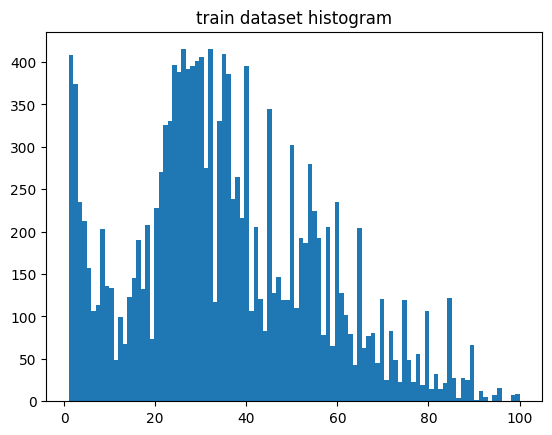

In [16]:
show_dl_hist(train_dl, 'train dataset histogram')

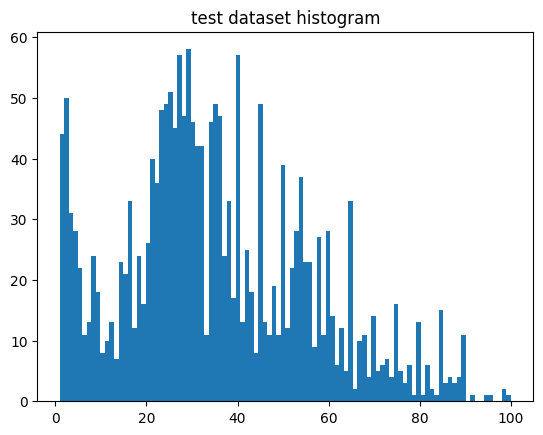

In [17]:
show_dl_hist(test_dl, 'test dataset histogram')

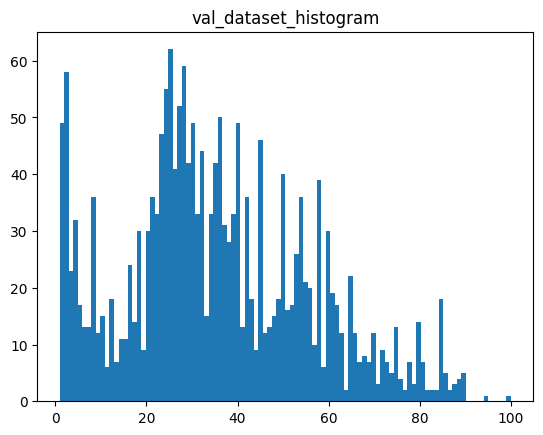

In [18]:
show_dl_hist(val_dl, 'val_dataset_histogram')

# Calculate weights for weighted loss function

In [71]:
train_labels = []
for i, data in enumerate(train_dl, 0):
    l = data[1].tolist()
    l = [round(x) for x in l]
    train_labels = train_labels + l

In [72]:
from scipy.signal import savgol_filter

count_occur = Counter(train_labels)
loss_weights = {}
loss_weights_array = np.zeros(100)
for key in train_labels:
    val = len(train_labels) / count_occur[key] / 100
    loss_weights[key] = val
    loss_weights_array[key-1] = val
loss_weights_array += 0.25
loss_weights_array = savgol_filter(loss_weights_array, 21, 2)
loss_weights_array = loss_weights_array / np.mean(loss_weights_array)

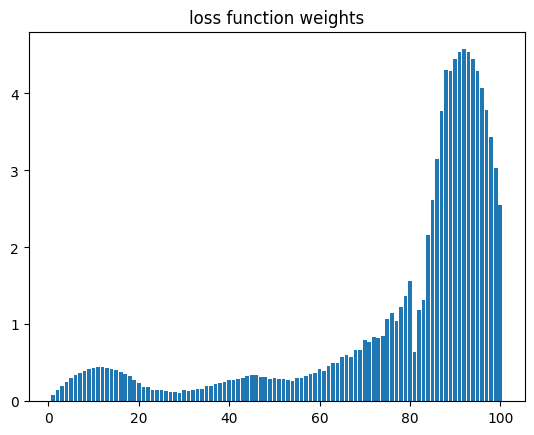

In [73]:
plt.bar(range(1,101), height=loss_weights_array)
plt.title('loss function weights')
plt.show()

In [74]:
loss_weights_tensor = torch.from_numpy(loss_weights_array).float().to(device).detach()

def weight_L1Loss(y_hat, y):
    loss = torch.mul(torch.abs(y_hat - y), loss_weights_tensor[y.long()-1])
    
    loss = torch.mean(loss)
    return loss

# Train

In [22]:
model = model.to(device)

In [75]:
def calculate_all(model, data_loader):
    result = None
    label = None
    for i, data in enumerate(data_loader, 0):
        out = model(data[0].to(device))
        if result is None:
            result = out
            label = data[1].to(device)
        else:
            result = torch.cat((result, out))
            label = torch.cat((label.to(device), data[1].to(device)))
    return result, label

In [110]:
loss_fn = nn.L1Loss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss = []
test_loss = []

lambda_1 = 2e-4

train_dl = DataLoader(train_dt, batch_size=batch_size, shuffle=True, num_workers=workers)

In [111]:
for epoch in range(num_epochs):
    epoch_train_loss = []
    for i, data in enumerate(train_dl, 0):
        if i % 50 == 0:
            print('[%d/%d]' % (i, len(train_dl)))
        model.zero_grad()

        output = model(data[0].to(device)).view(-1)
        
        all_params = torch.cat([x.view(-1) for x in model.head_network.parameters()])
        l1_regularization = lambda_1 * torch.norm(all_params, 1)
        train_mae = loss_fn(output, data[1].float().to(device))
        
        err_tr = train_mae + l1_regularization

        epoch_train_loss.append(train_mae.item())
        err_tr.backward()
        optimizer.step()
    train_loss.append(sum(epoch_train_loss) / len(epoch_train_loss))
    
    with torch.no_grad():
        test_output, test_labels = calculate_all(model, test_dl)
        err_test = loss_fn(test_output.view(-1).to(device), test_labels.to(device))
        test_loss.append(err_test.item())

    print('[%d/%d]\tTrain_loss: %.4f\tTest_loss: %.4f' % (epoch+1, num_epochs, train_loss[-1], test_loss[-1]))

[0/190]
[50/190]
[100/190]
[150/190]
[1/50]	Train_loss: 7.5038	Test_loss: 7.5131
[0/190]
[50/190]
[100/190]
[150/190]
[2/50]	Train_loss: 7.3590	Test_loss: 7.4609
[0/190]
[50/190]
[100/190]
[150/190]
[3/50]	Train_loss: 7.2756	Test_loss: 7.3996
[0/190]
[50/190]
[100/190]
[150/190]
[4/50]	Train_loss: 7.2048	Test_loss: 7.3805
[0/190]
[50/190]
[100/190]
[150/190]
[5/50]	Train_loss: 7.1395	Test_loss: 7.2874
[0/190]
[50/190]
[100/190]
[150/190]
[6/50]	Train_loss: 7.1016	Test_loss: 7.2670
[0/190]
[50/190]
[100/190]
[150/190]
[7/50]	Train_loss: 7.0511	Test_loss: 7.1688
[0/190]
[50/190]
[100/190]
[150/190]
[8/50]	Train_loss: 6.9416	Test_loss: 7.0499
[0/190]
[50/190]
[100/190]
[150/190]
[9/50]	Train_loss: 6.7878	Test_loss: 6.9153
[0/190]
[50/190]
[100/190]
[150/190]
[10/50]	Train_loss: 6.6145	Test_loss: 6.7557
[0/190]
[50/190]
[100/190]
[150/190]
[11/50]	Train_loss: 6.4820	Test_loss: 6.6087
[0/190]
[50/190]
[100/190]
[150/190]
[12/50]	Train_loss: 6.3851	Test_loss: 6.5459
[0/190]
[50/190]
[100/190

# Evaluate results

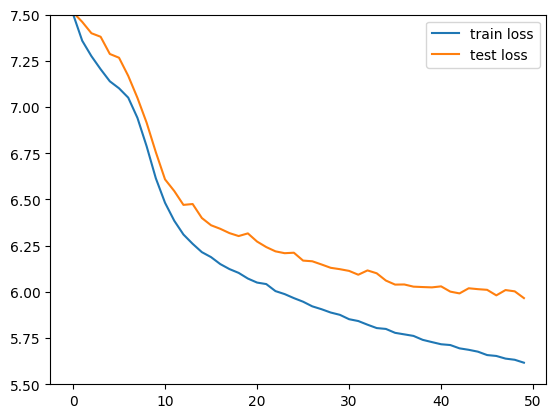

In [112]:
plt.plot(train_loss)
plt.plot(test_loss)
plt.ylim([5.5, 7.5])
plt.legend(['train loss', 'test loss'])
plt.show()

## Evaluate weighted error

In [86]:
with torch.no_grad():
    val_output, val_labels = calculate_all(model, val_dl)
    err_val = loss_fn(val_output.view(-1).to(device), val_labels.to(device))
    print(f'Weighted error for validation dataset is {err_val}')

Weighted error for validation dataset is 2.8053739174842334


## Evaluate MAE

In [115]:
with torch.no_grad():
    mae_loss = torch.nn.L1Loss(reduction='mean')
    
    val_output, val_labels = calculate_all(model, val_dl)
    val_labels = val_labels.reshape((val_labels.shape[0], 1))
    val_mae = mae_loss(val_output, val_labels).item()
    print(f'MAE for validation dataset is {val_mae}')
    
    test_output, test_labels = calculate_all(model, test_dl)
    test_labels = test_labels.reshape((test_labels.shape[0], 1))
    test_mae = mae_loss(test_output, test_labels).item()
    print(f'MAE for test dataset is {test_mae}')

MAE for validation dataset is 5.730579853057861
MAE for test dataset is 5.966320991516113


In [116]:
def test_img(img_path):
    test_img = cv2.imread(img_path)
    test_img = Image.fromarray(test_img, mode='RGB')
    
    test_img = transform(test_img).to(device).detach()
    test_img = test_img.reshape((1,3,test_img.shape[1],test_img.shape[2]))
    plt.imshow(plt.imread(img_path))
    dot = '.'
    age = float(model(test_img))
    # sage = age * 50 + 50
    age = round(age)
    plt.title(f'Photo of a {age} year old {img_path.split(dot)[0]}')
    plt.show()
    plt.savefig(f'age_{img_path}')
    print(model(test_img))

In [36]:
import importlib

In [64]:
importlib.reload(plt)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/dist-packages/matplotlib/pyplot.py'>

In [103]:
torch.use_deterministic_algorithms(False)
def plot_predict_hist(model, data_loader, name):
    plt.close()
    with torch.no_grad():
        result = None
        label = None
        for i, data in enumerate(data_loader, 0):
            out = model(data[0].to(device))
            if result is None:
                result = out
                label = data[1].to(device)
            else:
                result = torch.cat((result, out))
                label = torch.cat((label.to(device), data[1].to(device)))
        result = result.cpu().view(-1).numpy()
        
        fig = plt.figure(figsize=(12, 5))
        plt.title(f'{name} distribution')
        plt.axis('off')
        
        a = fig.add_subplot(1,2,1)
        sns.distplot(result, bins=20)
        a.set_title("Predicted age distribution")
        # plt.show()
        
        b = fig.add_subplot(1,2,2)
        sns.distplot(label.cpu().numpy(), bins=20)
        b.set_title("Actual age distribution")
        # plt.show()
        
        file_name = f'predict_distribution_{name}.png'
        if os.path.isfile(file_name):
            os.remove(file_name)
        # plt.savefig(file_name)
        plt.show()

## Distribution of predicted ages VS distribution of actual ages

/tmp/ipykernel_58/3134856587.py:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(result, bins=20)
/tmp/ipykernel_58/3134856587.py:27: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(label.cpu().numpy(), bins=20)


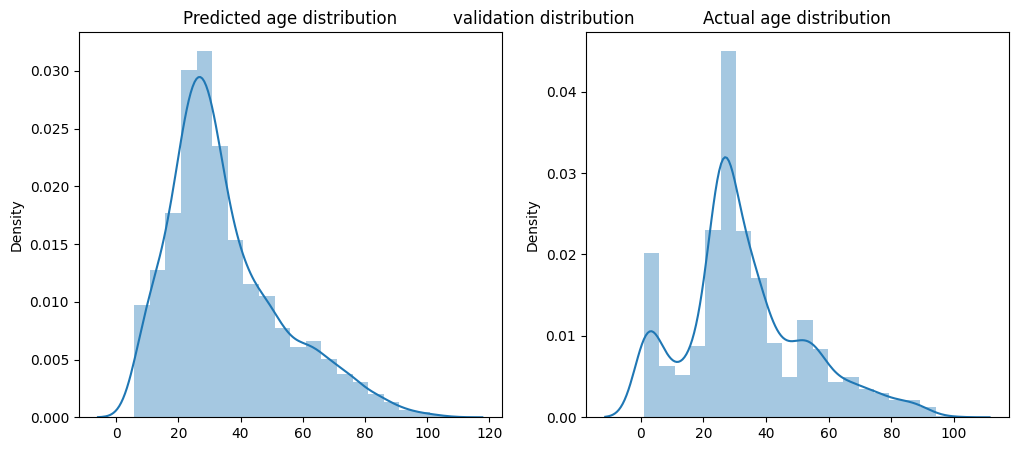

In [104]:
plot_predict_hist(model, val_dl, 'validation')

/tmp/ipykernel_58/3134856587.py:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(result, bins=20)
/tmp/ipykernel_58/3134856587.py:27: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(label.cpu().numpy(), bins=20)


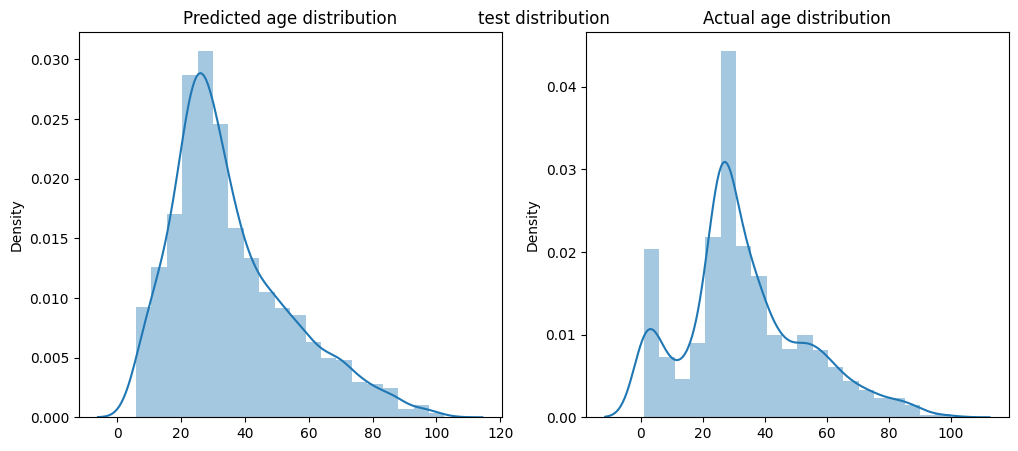

In [105]:
plot_predict_hist(model, test_dl, 'test')

/tmp/ipykernel_58/3134856587.py:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(result, bins=20)
/tmp/ipykernel_58/3134856587.py:27: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(label.cpu().numpy(), bins=20)


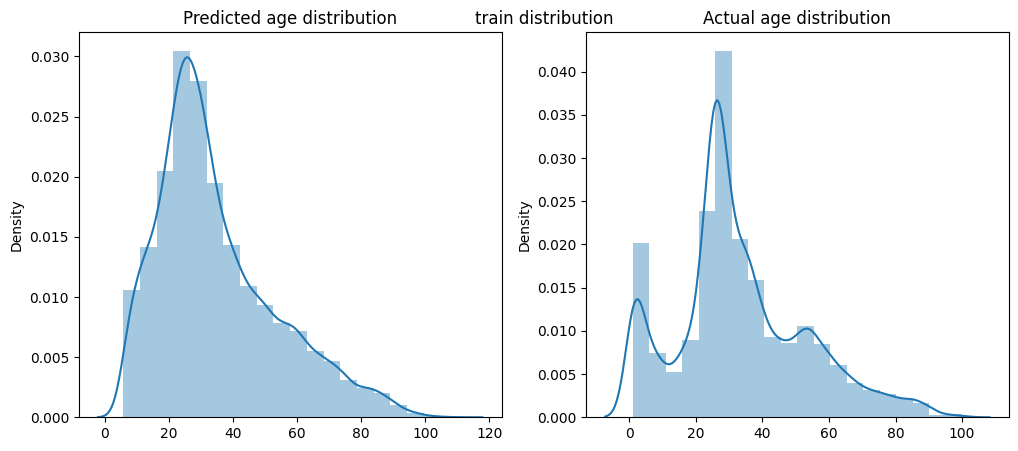

In [106]:
plot_predict_hist(model, train_dl, 'train')

In [11]:
torch.use_deterministic_algorithms(False)

# Show faces with different predicted ages

In [12]:
result = None
label = None
val_dict = {}

for i in range(1,101):
    val_dict[i] = []

for i, data in enumerate(val_dl, 0):
    print(f'{i+1} / {len(val_dl)}')
    out = model(data[0].to(device))
    if result is None:
        result = out
        label = data[1].to(device)
    else:
        result = torch.cat((result, out))
        label = torch.cat((label.to(device), data[1].to(device)))
    for a, i in zip(out.cpu().view(-1).detach().numpy().tolist(), data[0].cpu().detach().numpy().tolist()):
        a_int = round(a)
        if a_int < 1 or a_int > 100:
            continue
        val_dict[a_int].append(np.array(i))

1 / 2
2 / 2


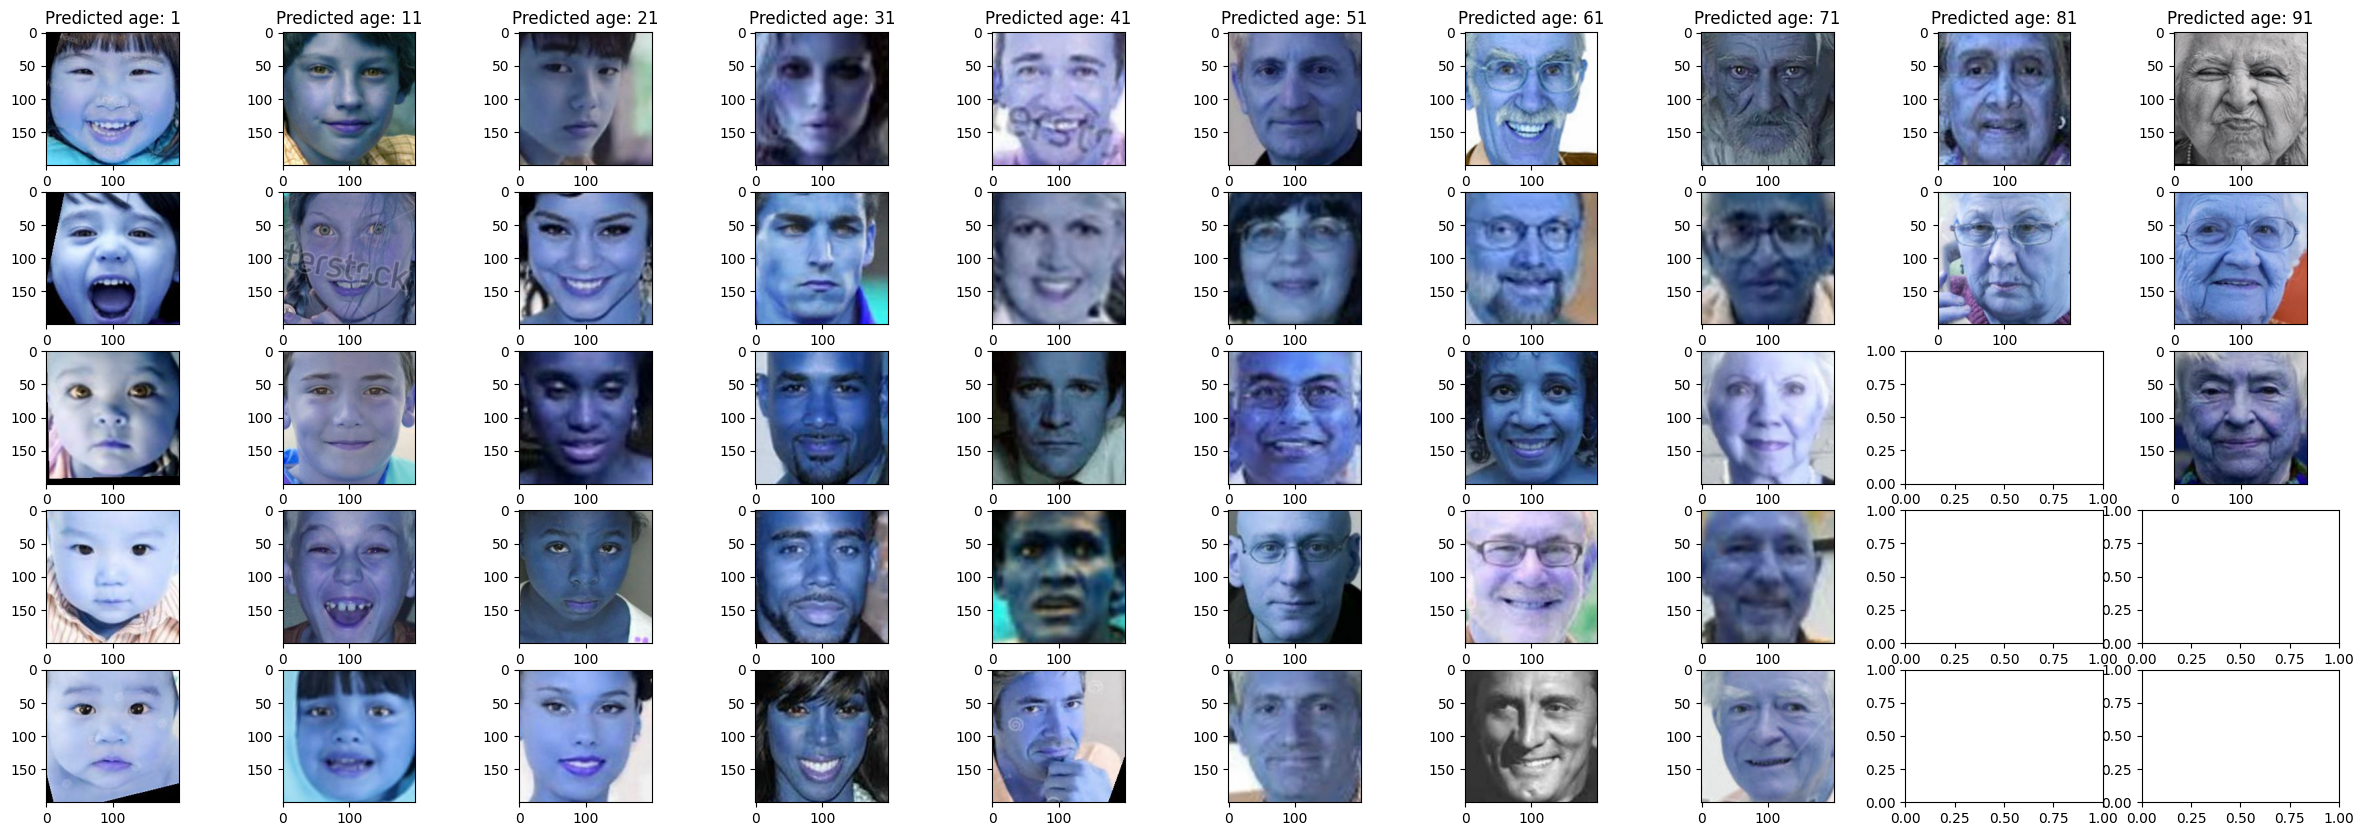

In [14]:
fig = plt.figure(figsize=(30, 10))
rows = 5
c = 0
ages = range(1,100,10)
for age in ages:
    for r in range(rows):
        a = fig.add_subplot(rows, len(ages), r*len(ages) + c+1)
        if r == 0:
            a.set_title(f'Predicted age: {age}')
        if r >= len(val_dict[age]):
            continue
        img = val_dict[age][r]
        img = np.clip(img, 0, 1)
        img = img.transpose((1, 2, 0))
        # img[:, :, 1], img[:, :, 0] = img[:, :, 0], img[:, :, 1]
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # print(img.shape)
        plt.imshow(img)
    c += 1

# Save model

In [126]:
torch.save(model, os.path.join('age_models', f'inception_2.pt'))